In [4]:
import numpy as np
import os 
import matplotlib.pyplot as plt
from Util import *
import torch
import pandas as pd

In [5]:
def load_data(folder, datalen):
    array_init=False
    
    ## Loop through data files in each folder
    for file in os.listdir(folder):
        if '.npy' in file:
            
            # Load the data
            data=np.load(os.path.join(folder,file),allow_pickle=True)
            #print(data)
            #Seperate states and input fields
            states = data[:datalen,1:]
            input_ = data[:datalen,0].reshape(-1,1)
            #print(input_)
            # Initialise the array for all states
            if array_init==False:
                data_all = states
                input_all = input_



                array_init = True
            else:
                if len(data)>(datalen-1):
                    data_all=np.concatenate([data_all[:datalen],data[:datalen]],axis=1)
                    input_all=np.concatenate([input_all[:datalen],input_[:datalen]],axis=1)
                else:
                    print('File has less data than required - ', file)
    return data_all, input_all
class DATA:
    
    def __init__(self,input_signal,datafolder,p_te,Task):
        
        T_data=250
        self.T_data=T_data
        states, inputs = load_data(datafolder,250)
        X= states
        Y=np.zeros((T_data,1))
        Y[:,0] = input_signal
        
         
        if Task=='MC':
            
            k_max=8
            self.k_max=k_max
            signal=np.copy(Y[:,0])
            
            Y=np.zeros([T_data-k_max,k_max])
            
            for k in range(k_max):
                
                Y[:,k]=signal[k_max-k-1:-k-1]
            
            X=np.copy(X[k_max:,:])
            
          
        if Task=='NL':
            
            k_max=8
            self.k_max=k_max
            signal=np.copy(Y[:,0])
            Y=np.zeros([T_data-k_max,k_max])
            
            for k in range(k_max):
                if k==0:
                    Y[:,k]=signal[k_max-k:]
                else:
                    Y[:,k]=signal[k_max-k:-k]
                
            X=np.copy(X[k_max:,1:])
            
            Var=np.var(X,0)
            Ch=np.argsort(Var)
            
            Ch=Ch[np.shape(Ch)[0]-60:]

            X=np.copy(X[:,Ch])
            
            X_M=np.max(np.abs(X),0)
            X=X/np.tile(np.expand_dims(X_M,0),[np.shape(X)[0],1])
            
            swap=np.copy(Y)
            Y=np.copy(X)
            X=np.copy(swap)
            
            
        
        
        self.Task=Task
                        
        self.X_original=X
        self.Y_original=Y
        
        self.X=X
        self.Y=Y
        
        self.X_tr=[]
        self.X_val=[]
        self.X_te=[]
        
        self.X_tr_M=[]
        self.X_val_M=[]
        self.X_te_M=[]
        
        self.Y_tr=[]
        self.Y_val=[]
        self.Y_te=[]
        
        self.it_ind=[]
        
        self.Corr=[]
        
        self.Cov=[]
        self.w=[]
        self.v=[]
        
        self.p_te=p_te
        
        self.index_tr=[]
        self.index_val=[]
        self.index_te=[]
        
        self.Z_val=[]
        self.Z_te=[]
        
    def CrossVal(self,te_ind,val_ind):
    
        N_data=np.shape(self.X)[0]
        
        N_trans=20
        
        N_te=int(np.floor((N_data-N_trans)*self.p_te))
        
        N_val=int(np.floor((N_data-N_trans-N_te)*0.1))
        
        index=np.arange(N_trans,N_data)
        
        index_te=np.copy(index[te_ind*N_te:(te_ind+1)*N_te])
        index_noT=np.delete(index,index_te-N_trans)
        
        index_val=np.copy(index_noT[val_ind*N_val:(val_ind+1)*N_val])
        
        index_tr=np.delete(index,np.concatenate([index_te-N_trans,index_val-N_trans],0))
        
        
        X_tr=np.copy(self.X[index_tr,:])
        
        X_M=np.max(np.abs(X_tr),0)
        
        X_tr=X_tr/np.tile(np.expand_dims(X_M,0),[np.shape(X_tr)[0],1])
        X_val=np.copy(self.X[index_val,:])/np.tile(np.expand_dims(X_M,0),[N_val,1])
        X_te=np.copy(self.X[index_te,:])/np.tile(np.expand_dims(X_M,0),[N_te,1])
        
        Y_tr=np.copy(self.Y[index_tr,:])
        Y_val=np.copy(self.Y[index_val,:])
        Y_te=np.copy(self.Y[index_te,:])
        
        self.X_tr_M=np.copy(X_tr)
        self.X_val_M=np.copy(X_val)
        self.X_te_M=np.copy(X_te)
        
        self.Y_tr_M=np.copy(Y_tr)
        self.Y_val_M=np.copy(Y_val)
        self.Y_te_M=np.copy(Y_te)
        
        self.X_tr=torch.from_numpy(X_tr).float()
        self.X_te=torch.from_numpy(X_te).float()
        self.X_val=torch.from_numpy(X_val).float()
        
        self.Y_tr=torch.from_numpy(Y_tr).float()
        self.Y_te=torch.from_numpy(Y_te).float()
        self.Y_val=torch.from_numpy(Y_val).float()
        
        self.index_val=index_val
        self.index_te=index_te
        
        
    def CORR(self):
        
        Corr=np.corrcoef(np.transpose(self.X_tr_M))
        
        self.Corr=Corr
        
        
    def CORR_Analysis(self,th,removal):
        
        
        N=np.shape(self.Corr)[0]
        
        N_red=np.abs(self.Corr)>th
        
        RM=[]
        
        for i in range(N):
            
            if any(N_red[i,:]==1):
                
                
                ind=np.where(N_red[i,:]==1)[0]
                
                if any(ind>i):
                    
                    RM.append(i)
        
        RM=np.array(RM)
        
        
        if removal==True and RM!=[]:
                
            self.X_tr_M=np.delete(self.X_tr,RM,1)    
            self.X_val_M=np.delete(self.X_val,RM,1)
            self.X_te_M=np.delete(self.X_te,RM,1)
            
        else:
            
            self.X_tr_M=self.X_tr    
            self.X_val_M=self.X_val
            self.X_te_M=self.X_te
            
        
        return RM
    
    def Benchmark_Correlation(self,ths):
        
        
        N_fit=np.shape(ths)[0]
        

        alphas=np.array([1e-4,1e-3,1e-2,5*1e-2,1*1e-1])        
        N_alpha=np.shape(alphas)[0]
        
        N_out=np.shape(self.Y_tr)[1]
        
        N_split=10
        
        N=np.shape(self.X_tr_M)[1]
        
        N_split_te=int(1/self.p_te)
        
        RM=np.zeros([N_split_te,N])
        
        Best_hyper=np.zeros([N_split_te,3])
        
        
        MSE_Te=np.zeros([N_split_te,N_out])
        MSE_Val=np.zeros([N_split_te])
        MSE_Tr=np.zeros([N_split_te])
        
        Z_val=np.zeros([N_split_te,self.T_data,N_out,2])
        Z_te=np.zeros([self.T_data,N_out,2])
        
        for l in range(N_split_te):
            
            mse_Val=np.zeros([N_split,np.shape(ths)[0],N_alpha,N_out])
            mse_Tr=np.zeros([N_split,np.shape(ths)[0],N_alpha,N_out])
            O_val=np.zeros([N_fit,N_alpha,self.T_data,N_out,2])
        
            for j in range(N_split):
                
                self.CrossVal(l,j)
                self.CORR()
                
                
                for i in range(N_fit):
                                    
                    _=self.CORR_Analysis(ths[i],True)
                                    
                    
                    for k in range(N_alpha):
                
                        model=Ridge(alpha = alphas[k],fit_intercept = False,copy_X = True)
                        reg = model.fit(self.X_tr_M, self.Y_tr_M)
            
                        output_val = reg.predict(self.X_val_M)
                        output_train = reg.predict(self.X_tr_M)
                        O_val[i,k,self.index_val,:,0]=np.copy(output_val)
                        O_val[i,k,self.index_val,:,1]=np.copy(self.Y_val_M)
                        
                        mse_Tr[j,i,k,:] = np.mean((self.Y_tr_M-output_train)**2,0)
                        mse_Val[j,i,k,:] = np.mean((self.Y_val_M-output_val)**2,0)
                        
                        
            M_Tr=np.mean(np.mean(mse_Tr,0),2) 
            M_Val=np.mean(np.mean(mse_Val,0),2) 
            
            ind=np.argwhere(M_Val==np.min(M_Val))[0]
            
            MSE_Val[l]=np.copy(M_Val[ind[0],ind[1]])
            MSE_Tr[l]=np.copy(M_Tr[ind[0],ind[1]])
    
            Z_val[l,:,:,0]=np.copy(O_val[ind[0],ind[1],:,:,0])
            Z_val[l,:,:,1]=np.copy(O_val[ind[0],ind[1],:,:,1])
            
            self.X_tr_M=np.concatenate([self.X_tr,self.X_val],0)
            
            self.CORR()
            
            EL_removed=self.CORR_Analysis(ths[ind[0]],True)
            
            if EL_removed!=[]:
                RM[l,EL_removed]=1
            
                
            Best_hyper[l,0]=ths[ind[0]]
            Best_hyper[l,1]=alphas[ind[1]]
            Best_hyper[l,2]=np.sum(RM[l,:]==0)
            
            self.X_tr_M=np.concatenate([self.X_tr_M,self.X_val_M],0)
            self.Y_tr_M=np.concatenate([self.Y_tr_M,self.Y_val_M],0)
            
            model=Ridge(alpha = alphas[ind[1]],fit_intercept = False,copy_X = True)
            reg = model.fit(self.X_tr_M, self.Y_tr_M)
            
            output_test = reg.predict(self.X_te_M)
            
            MSE_Te[l,:] = np.mean((self.Y_te_M-output_test)**2,0)
                
            
            Z_te[self.index_te,:,0]=np.copy(output_test)
            Z_te[self.index_te,:,1]=np.copy(self.Y_te_M)
            
        
        print('Performance: TE, ', np.mean(MSE_Te), 'VAL ', np.mean(MSE_Val), 'TR ', np.mean(MSE_Tr))

        
        return MSE_Tr, MSE_Val, MSE_Te, RM, Best_hyper, Z_val, Z_te
    
    def Measure_MC(self,ths):
        
        MSE_Tr, MSE_Val, MSE_Te, RM, Best_hyper, Z_val, Z_te=self.Benchmark_Correlation(ths)
        
        MC=np.zeros([np.shape(Z_te)[1]])
        
        for k in range(np.shape(Z_te)[1]):
            
            ind_te=np.where(Z_te[:,k,0]!=0)
            u_test=np.copy(Z_te[ind_te,k,0])
            u_pred=np.copy(Z_te[ind_te,k,1])
            
            MC[k]=( np.mean(u_test*u_pred) - np.mean(u_test)*np.mean(u_pred) )**2 / (np.var(u_test) * np.var(u_pred))
        
        
        print('MC: ', np.sum(MC))
        
        return MSE_Tr, MSE_Val, MSE_Te, RM, Best_hyper, Z_val, Z_te, MC
    
    
    def Measure_NL(self):
        
        k_min=5
        N_fit=self.k_max-k_min
        Ks=np.arange(k_min,self.k_max+1)

        alphas=np.array([1e-4,1e-3,1e-2,5*1e-2,1*1e-1])        
        N_alpha=np.shape(alphas)[0]
        
        N_out=np.shape(self.Y_tr)[1]
        
        N_split=10
        
        N_split_te=int(1/self.p_te)
        
        Best_hyper=np.zeros([N_split_te,3])
        
        MSE_Te=np.zeros([N_split_te,N_out])
        MSE_Val=np.zeros([N_split_te])
        MSE_Tr=np.zeros([N_split_te])
        
        Z_val=np.zeros([N_split_te,self.T_data,N_out,2])
        Z_te=np.zeros([self.T_data,N_out,2])
        
        for l in range(N_split_te):
            
            mse_Val=np.zeros([N_split,N_fit,N_alpha,N_out])
            mse_Tr=np.zeros([N_split,N_fit,N_alpha,N_out])
            O_val=np.zeros([N_fit,N_alpha,self.T_data,N_out,2])
        
            for j in range(N_split):
                
                self.CrossVal(l,j)
                
                for i in range(N_fit):
                                    
                    self.X_tr_M=np.copy(self.X_tr[:,0:Ks[i]])    
                    self.X_val_M=np.copy(self.X_val[:,0:Ks[i]])
                    self.X_te_M=np.copy(self.X_te[:,0:Ks[i]])
                                    
                    for k in range(N_alpha):
                
                        model=Ridge(alpha = alphas[k],fit_intercept = False,copy_X = True)
                        reg = model.fit(self.X_tr_M, self.Y_tr_M)
            
                        output_val = reg.predict(self.X_val_M)
                        output_train = reg.predict(self.X_tr_M)
                        O_val[i,k,self.index_val,:,0]=np.copy(output_val)
                        O_val[i,k,self.index_val,:,1]=np.copy(self.Y_val_M)
                        
                        mse_Tr[j,i,k,:] = np.mean((self.Y_tr_M-output_train)**2,0)
                        mse_Val[j,i,k,:] = np.mean((self.Y_val_M-output_val)**2,0)
                        
                  
            M_Tr=np.mean(np.mean(mse_Tr,0),2) 
            M_Val=np.mean(np.mean(mse_Val,0),2) 
            
            
            ind=np.argwhere(M_Val==np.min(M_Val))[0]
            
            MSE_Val[l]=np.copy(M_Val[ind[0],ind[1]])
            MSE_Tr[l]=np.copy(M_Tr[ind[0],ind[1]])
    
            Z_val[l,:,:,0]=np.copy(O_val[ind[0],ind[1],:,:,0])
            Z_val[l,:,:,1]=np.copy(O_val[ind[0],ind[1],:,:,1])
            
            self.X_tr_M=np.concatenate([self.X_tr,self.X_val],0)
            self.X_tr_M=self.X_tr_M[:,0:Ks[ind[0]]]
            self.X_te_M=self.X_te_M[:,0:Ks[ind[0]]]
            
            self.Y_tr_M=np.concatenate([self.Y_tr_M,self.Y_val_M],0)
            
            
            Best_hyper[l,0]=Ks[ind[0]]
            Best_hyper[l,1]=alphas[ind[1]]

            model=Ridge(alpha = alphas[ind[1]],fit_intercept = False,copy_X = True)
            reg = model.fit(self.X_tr_M, self.Y_tr_M)
            
            output_test = reg.predict(self.X_te_M)
            
            MSE_Te[l,:] = np.mean((self.Y_te_M-output_test)**2,0)
                
            
            Z_te[self.index_te,:,0]=np.copy(output_test)
            Z_te[self.index_te,:,1]=np.copy(self.Y_te_M)
            
        
        print('Performance: TE, ', np.mean(MSE_Te), 'VAL ', np.mean(MSE_Val), 'TR ', np.mean(MSE_Tr))
        
        MC=np.zeros([np.shape(Z_te)[1]])
        
        for k in range(np.shape(Z_te)[1]):
            
            ind_te=np.where(Z_te[:,k,0]!=0)
            u_test=np.copy(Z_te[ind_te,k,0])
            u_pred=np.copy(Z_te[ind_te,k,1])
            
            MC[k]=( np.mean(u_test*u_pred) - np.mean(u_test)*np.mean(u_pred) )**2 / (np.var(u_test) * np.var(u_pred))
        
        
        NL=1-np.mean(MC)
        
        print('NL: ', NL)
        return MSE_Tr, MSE_Val, MSE_Te, Best_hyper, Z_val, Z_te, NL
        
    
    
    def Evolutionary(self, Feats, p_mutation, N_iteration, alphas):
        
        Parents_in=False
        
        N_children=200
        N_split=10
        N_best=10
        
        N_split_te=int(1/self.p_te)
        
        N_out=np.shape(self.Y)[1]
        N_feat=np.shape(self.X)[1]

        MSE1=np.zeros([N_split_te,N_iteration,N_best,N_out])
        MSE2=np.zeros([N_split_te,N_iteration,N_best,N_out])
        
        Z_val=np.zeros([N_split_te,self.T_data,N_out,3])
        Z_te=np.zeros([self.T_data,N_out,2])
        
        MSE=[]
        MSE_bench=[]
        
        for split in range(N_split_te):
            
            Mask=np.copy(Feats[split,:])
            
            alpha=np.copy(alphas[split])
            
            model=Ridge(alpha = alpha,fit_intercept = False,copy_X = True)
            best_ch=[]

            self.CrossVal(split,9)

            N_te=np.shape(self.X_te)[0]
            N_te=int(N_te/2)
            
            index_te1=self.index_te[0:N_te]
            index_te2=self.index_te[N_te:]
            
            X_te1=np.copy(self.X_te[0:N_te,:])
            Y_te1=np.copy(self.Y_te[0:N_te,:])

            X_te2=np.copy(self.X_te[N_te:,:])
            Y_te2=np.copy(self.Y_te[N_te:,:])

            MSE_te1=np.zeros([N_iteration,N_best])
            MSE_te2=np.zeros([N_iteration,N_best])

            RM=np.where(Mask==1)

            X_te1_M=np.delete(X_te1,RM,1)
            X_te2_M=np.delete(X_te2,RM,1)

            self.X_tr_M=np.delete(np.concatenate([self.X_tr,self.X_val],0),RM,1)
            self.Y_tr_M=np.concatenate([self.Y_tr,self.Y_val],0)

            reg=model.fit(self.X_tr_M, self.Y_tr_M)

            MSE_bench.append(np.mean((Y_te1-reg.predict(X_te1_M))**2))
            MSE_bench.append(np.mean((Y_te2-reg.predict(X_te2_M))**2))
            
            print('Split Number ', split)
            print('Before Evolution: ', MSE_bench[-2],MSE_bench[-1])
            
            if Parents_in:

                N_loop=N_children+N_best

            if not(Parents_in):
                
                N_loop=N_children
            
            
            O_val=np.zeros([N_iteration,N_loop,self.T_data,N_out,2])
            O_te=np.zeros([N_iteration,N_best,self.T_data,N_out,2])
            
            for n in range(N_iteration):

                if n==0:    

                    if Parents_in:

                        Masks=np.tile(np.expand_dims(Mask,1),[1,N_children+N_best])

                    if not(Parents_in):

                        Masks=np.tile(np.expand_dims(Mask,1),[1,N_children])


                else:

                    Parents=np.copy(Masks[:,best_ch])

                    ind_mix=np.random.permutation(N_best)
                    Masks=np.zeros([N_feat,N_children])
                    N_mix=int(2*N_children/N_best)

                    for l in range(int(N_best/2)):

                        cross=np.random.rand(N_feat,N_mix)<0.5

                        Masks[:,N_mix*l:N_mix*(l+1)]=np.tile(np.expand_dims(Parents[:,ind_mix[2*l]],1),[1,N_mix])*cross+np.tile(np.expand_dims(Parents[:,ind_mix[2*l+1]],1),[1,N_mix])*(1-cross)


                    if Parents_in:

                        Masks=np.concatenate([Masks,Parents],1)


                Mutations=np.random.rand(N_feat,N_children)<p_mutation

                if Parents_in:

                    Masks[:,0:N_children]=Masks[:,0:N_children]*(1-Mutations)+(1-Masks[:,0:N_children])*Mutations

                if not(Parents_in):
                    
                    Masks=Masks*(1-Mutations)+(1-Masks)*Mutations

                MSE_val=np.zeros([N_loop,N_split])
                                
                for i in range(N_loop):

                    RM=np.where(Masks[:,i]==1)


                    for j in range(N_split):

                        self.CrossVal(split,j)

                        self.X_tr_M=np.delete(self.X_tr,RM,1)    
                        self.X_val_M=np.delete(self.X_val,RM,1)

                        reg=model.fit(self.X_tr_M, self.Y_tr_M)

                        MSE_val[i,j]=np.mean((self.Y_val_M-reg.predict(self.X_val_M))**2)
                        
                        O_val[n,i,self.index_val,:,0]= reg.predict(self.X_val_M)
                        O_val[n,i,self.index_val,:,1]= np.copy(self.Y_val_M)
                                                
                        
                best_ch=np.argsort(np.mean(MSE_val,1))[0:N_best]
                
                O_val[:,0:N_best,:,:]=O_val[:,best_ch,:,:,:]
                
                for i in range(N_best):

                    RM=np.where(Masks[:,best_ch[i]]==1)

                    self.X_tr_M=np.delete(np.concatenate([self.X_tr,self.X_val],0),RM,1)
                    self.Y_tr_M=np.concatenate([self.Y_tr,self.Y_val],0)

                    reg=model.fit(self.X_tr_M, self.Y_tr_M)

                    X_te1_M=np.delete(X_te1,RM,1)
                    X_te2_M=np.delete(X_te2,RM,1)
                    
                    MSE1[split,n,i,:]=np.mean((Y_te1-reg.predict(X_te1_M))**2,0)
                    MSE2[split,n,i,:]=np.mean((Y_te2-reg.predict(X_te2_M))**2,0)
                    
                    MSE_te1[n,i]=np.mean(MSE1[split,n,i,:])
                    MSE_te2[n,i]=np.mean(MSE2[split,n,i,:])
                    
                    O_te[n,i,index_te1,:,0]= reg.predict(X_te1_M)
                    O_te[n,i,index_te2,:,0]= reg.predict(X_te2_M)
                    O_te[n,i,index_te1,:,1]= np.copy(Y_te1)
                    O_te[n,i,index_te2,:,1]= np.copy(Y_te2)
                    
            O_val=O_val[:,0:N_best,:,:]
            
            ind1=np.argwhere(MSE_te1==np.min(MSE_te1))[0]
            ind2=np.argwhere(MSE_te2==np.min(MSE_te2))[0]
            
            Z_val[split,:,:,0]=np.copy(O_val[ind2[0],ind2[1],:,:,0])
            Z_val[split,:,:,1]=np.copy(O_val[ind1[0],ind1[1],:,:,0])
            Z_val[split,:,:,2]=np.copy(O_val[ind1[0],ind1[1],:,:,1])
            
            Z_te[index_te1,:,0]=O_te[ind2[0],ind2[1],index_te1,:,0]
            Z_te[index_te2,:,0]=O_te[ind1[0],ind1[1],index_te2,:,0]
            Z_te[self.index_te,:,1]=O_te[ind1[0],ind1[1],self.index_te,:,1]
            
            
            MSE.append(MSE1[split,ind2[0],ind2[1],:])
            MSE.append(MSE2[split,ind1[0],ind1[1],:])
            
            print('After Evolution: ', MSE_te1[ind2[0],ind2[1]],MSE_te2[ind1[0],ind1[1]], ind1[0], ind2[0])
            print('Minima (Overfitting): ', np.min(MSE_te1),np.min(MSE_te2))
        
        MSE=np.array(MSE)
        MSE_bench=np.array(MSE_bench)
        
        print('Overall, Before and After: ', np.mean(MSE_bench), np.mean(MSE))
            
        return MSE, MSE_bench, Z_val, Z_te


In [6]:
## Analyse the memory and nonlinearity for a single folder

import warnings
warnings.filterwarnings('ignore')
base = os.path.split(os.getcwd())[0]
datafolder = os.path.join(base,r'Data\Mackey_Glass\Single\WM')

MG = np.load(os.path.join(base,'mackey_glass_t17.npy'))
MG_new = []
for i in range(250):
    MG_new.append(MG[2*i])
MG_new =  (MG_new-np.min(MG_new))/(np.max(MG_new)-np.min((MG_new)))

ths=np.array([0.999, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92])

MSE_Tr1=[]
MSE_Val1=[]
MSE_Te1=[]

Feats1=[]
Best_hyper1=[]
Z_val1=[]
Z_te1=[]
MC1=[]

p_te=0.2
Task='MC'

Data=DATA(MG_new,datafolder,p_te,Task)

Data.CrossVal(4,1)
Data.CORR()


MSE_tr, MSE_val, MSE_te, RM, Best_hyper, Z_val, Z_te, MC=Data.Measure_MC(ths)

Task='NL'

Data=DATA(MG_new,datafolder,p_te,Task)

Data.CrossVal(4,1)
Data.CORR()

MSE_tr, MSE_val, MSE_te, Best_hyper, Z_val, Z_te, NL=Data.Measure_NL()

MSE_Tr1.append(MSE_tr)
MSE_Val1.append(MSE_val)
MSE_Te1.append(MSE_te)


    
Feats1.append(RM)

Best_hyper1.append(Best_hyper)
Z_val1.append(Z_val)
Z_te1.append(Z_te)
MC1.append([MC,NL])
print(MC1)    

Performance: TE,  0.019720494691754294 VAL  0.019320703354700403 TR  0.013328739580271509
MC:  5.684462555971038
Performance: TE,  0.028289545078935784 VAL  0.030517544340520043 TR  0.026887549772325804
NL:  0.39145056431752834
[[array([0.97269238, 0.89646285, 0.79598231, 0.69772286, 0.61610647,
       0.56457934, 0.555491  , 0.58542535]), 0.39145056431752834]]


In [75]:
## Analyse the memory and nonlinearity for all networks

folder = os.ath.join(base,r'Data\Mackey_Glass')
all_={}
for type_ in os.listdir(folder):
    typefolder = os.path.join(folder,type_)
    if os.path.isdir(typefolder):
        for network in os.listdir(typefolder):
            netfold = os.path.join(typefolder,network)
            if os.path.isdir(netfold) and 'All_data' not in netfold and 'PNN' not in netfold and 'Individual' not in netfold:
                MG = np.load('mackey_glass_t17.npy')
                MG_new = []
                for i in range(250):
                    MG_new.append(MG[2*i])
                MG_new =  (MG_new-np.min(MG_new))/(np.max(MG_new)-np.min((MG_new)))

                ths=np.array([0.999, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92])

                MC1=[]

                p_te=0.2
                Task='MC'

                Data=DATA(MG_new,netfold,p_te,Task)

                Data.CrossVal(4,1)
                Data.CORR()


                MSE_tr, MSE_val, MSE_te, RM, Best_hyper, Z_val, Z_te, MC=Data.Measure_MC(ths)

                Task='NL'

                Data=DATA(MG_new,netfold,p_te,Task)

                Data.CrossVal(4,1)
                Data.CORR()

                MSE_tr, MSE_val, MSE_te, Best_hyper, Z_val, Z_te, NL=Data.Measure_NL()


                all_[network]=[MC,NL]
                print(network,np.sum(MC),NL)    



Performance: TE,  0.01984951826055072 VAL  0.01919063717705754 TR  0.011848497340142868
MC:  5.701448744024238
Performance: TE,  0.025423555181395763 VAL  0.02744240902421923 TR  0.02420646578036844
NL:  0.3286789748198101
P1 5.701448744024238 0.3286789748198101
Performance: TE,  0.03643531222070107 VAL  0.03716524595693007 TR  0.015871436120488025
MC:  3.9668515453515436
Performance: TE,  0.061406144543928225 VAL  0.0652332264521085 TR  0.05769437458635891
NL:  0.7238190950935627
P2 3.9668515453515436 0.7238190950935627
Performance: TE,  0.021419408364479246 VAL  0.019007603709834186 TR  0.0111073609056898
MC:  5.521549647128529
Performance: TE,  0.058283915255474855 VAL  0.06273235119472116 TR  0.05431884974359487
NL:  0.6504355102064932
P3 5.521549647128529 0.6504355102064932
Performance: TE,  0.020358321390686062 VAL  0.019467861539755615 TR  0.011470703361129353
MC:  5.668388455539085
Performance: TE,  0.05775432746202085 VAL  0.06221163339783016 TR  0.05383103360353943
NL:  0.648

In [77]:
print(all_)
import pickle
with open(r'metrics.pkl', 'wb') as fp:
    pickle.dump(all_, fp)
    print('dictionary saved successfully to file')

{'P1': [array([0.97338146, 0.90144226, 0.80399027, 0.70223043, 0.61307596,
       0.5581642 , 0.5544227 , 0.59474146]), 0.3286789748198101], 'P2': [array([0.92833056, 0.76477386, 0.56105091, 0.38723178, 0.29338291,
       0.28291018, 0.33243453, 0.41673681]), 0.7238190950935627], 'P3': [array([0.97278312, 0.8966126 , 0.78432691, 0.66321298, 0.56792166,
       0.52293368, 0.53261219, 0.5811465 ]), 0.6504355102064932], 'Pall': [array([0.97350041, 0.90146927, 0.80094841, 0.6953924 , 0.606711  ,
       0.5538905 , 0.54903389, 0.58744257]), 0.6481279962555984], 'S1': [array([0.90441638, 0.6834542 , 0.4105862 , 0.18161143, 0.05367056,
       0.02240727, 0.05863834, 0.16578229]), 0.3685616491404089], 'S10': [array([0.97010303, 0.89989223, 0.80059407, 0.69509454, 0.60557186,
       0.54876588, 0.52913563, 0.54055814]), 0.32141103605597066], 'S11': [array([8.94947916e-01, 6.58714260e-01, 3.66866837e-01, 1.29020610e-01,
       1.49165155e-02, 5.24378506e-04, 2.32434092e-02, 1.26875543e-01]), 0.7

In [84]:
## Load the .pkl files with the various tasks. task+'under' has results where the PNN is forced to be in the underparameterised state by changing the theta values for the correlation

objects = []
import pickle

with open('metrics.pkl', "rb") as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
print(objects[0]['MS'][1])

0.3771467686801697


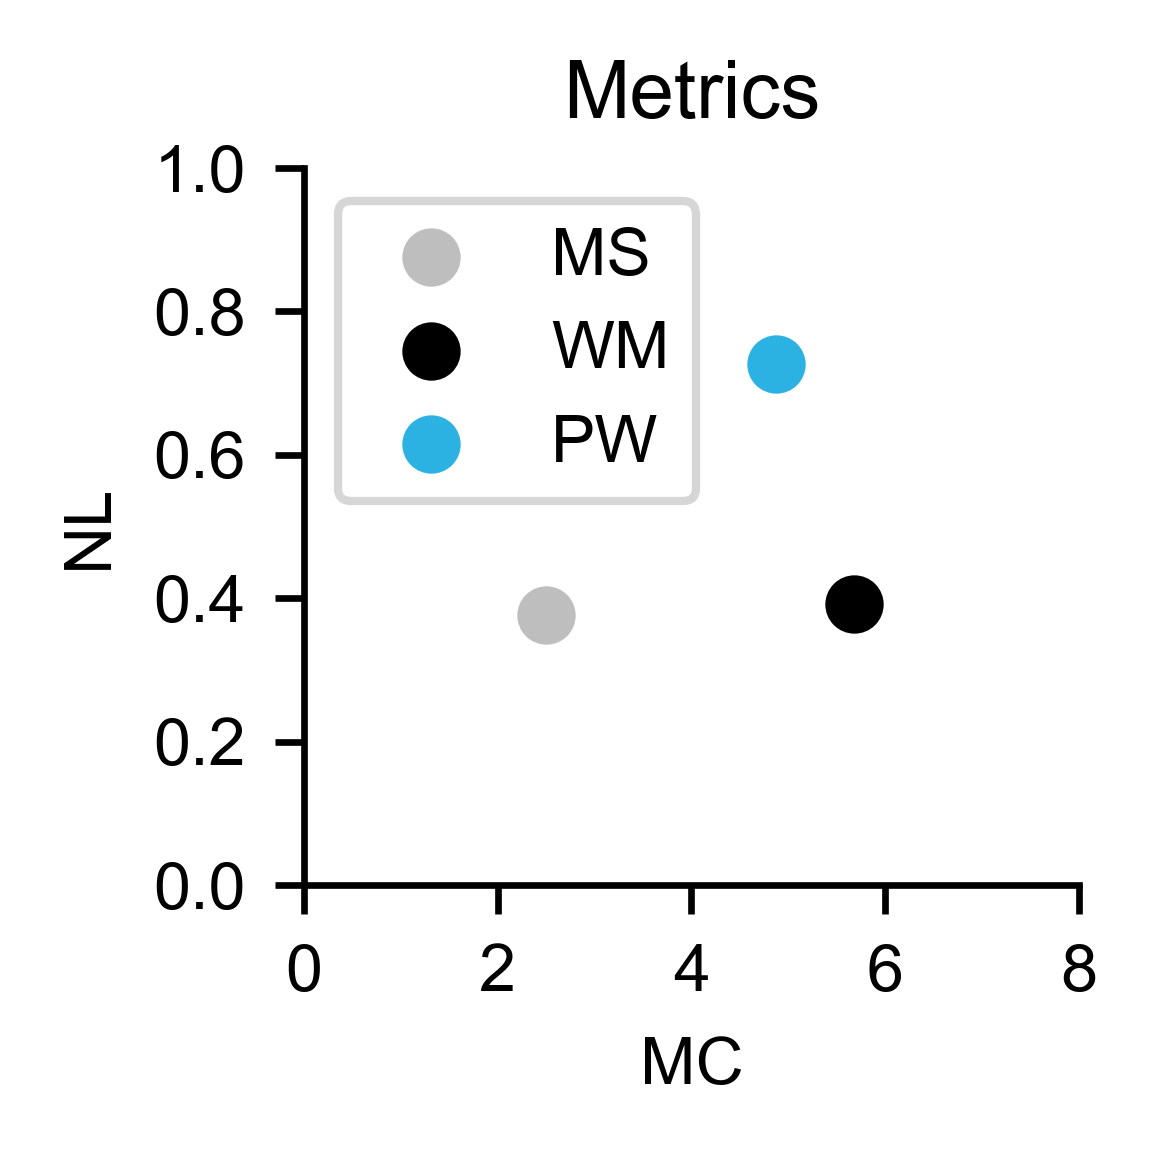

In [86]:
#Single 
fig,ax = plt.subplots(1,1,figsize = (5*cm,5*cm))
c_list = ['#BEBEBE','k','#2BB2E3']
names= ['MS','WM','PW']
for i in range(3):
    data = objects[0][names[i]]
    MC = np.sum(data[0])
    NL = data[1]
    ax.scatter(MC,NL,c=c_list[i],label=names[i])
plt.xlim(0,8)
plt.ylim(0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('MC')
ax.set_ylabel('NL')

ax.set_xticks([0,2,4,6,8])
plt.title('Metrics')
plt.legend()
plt.tight_layout()



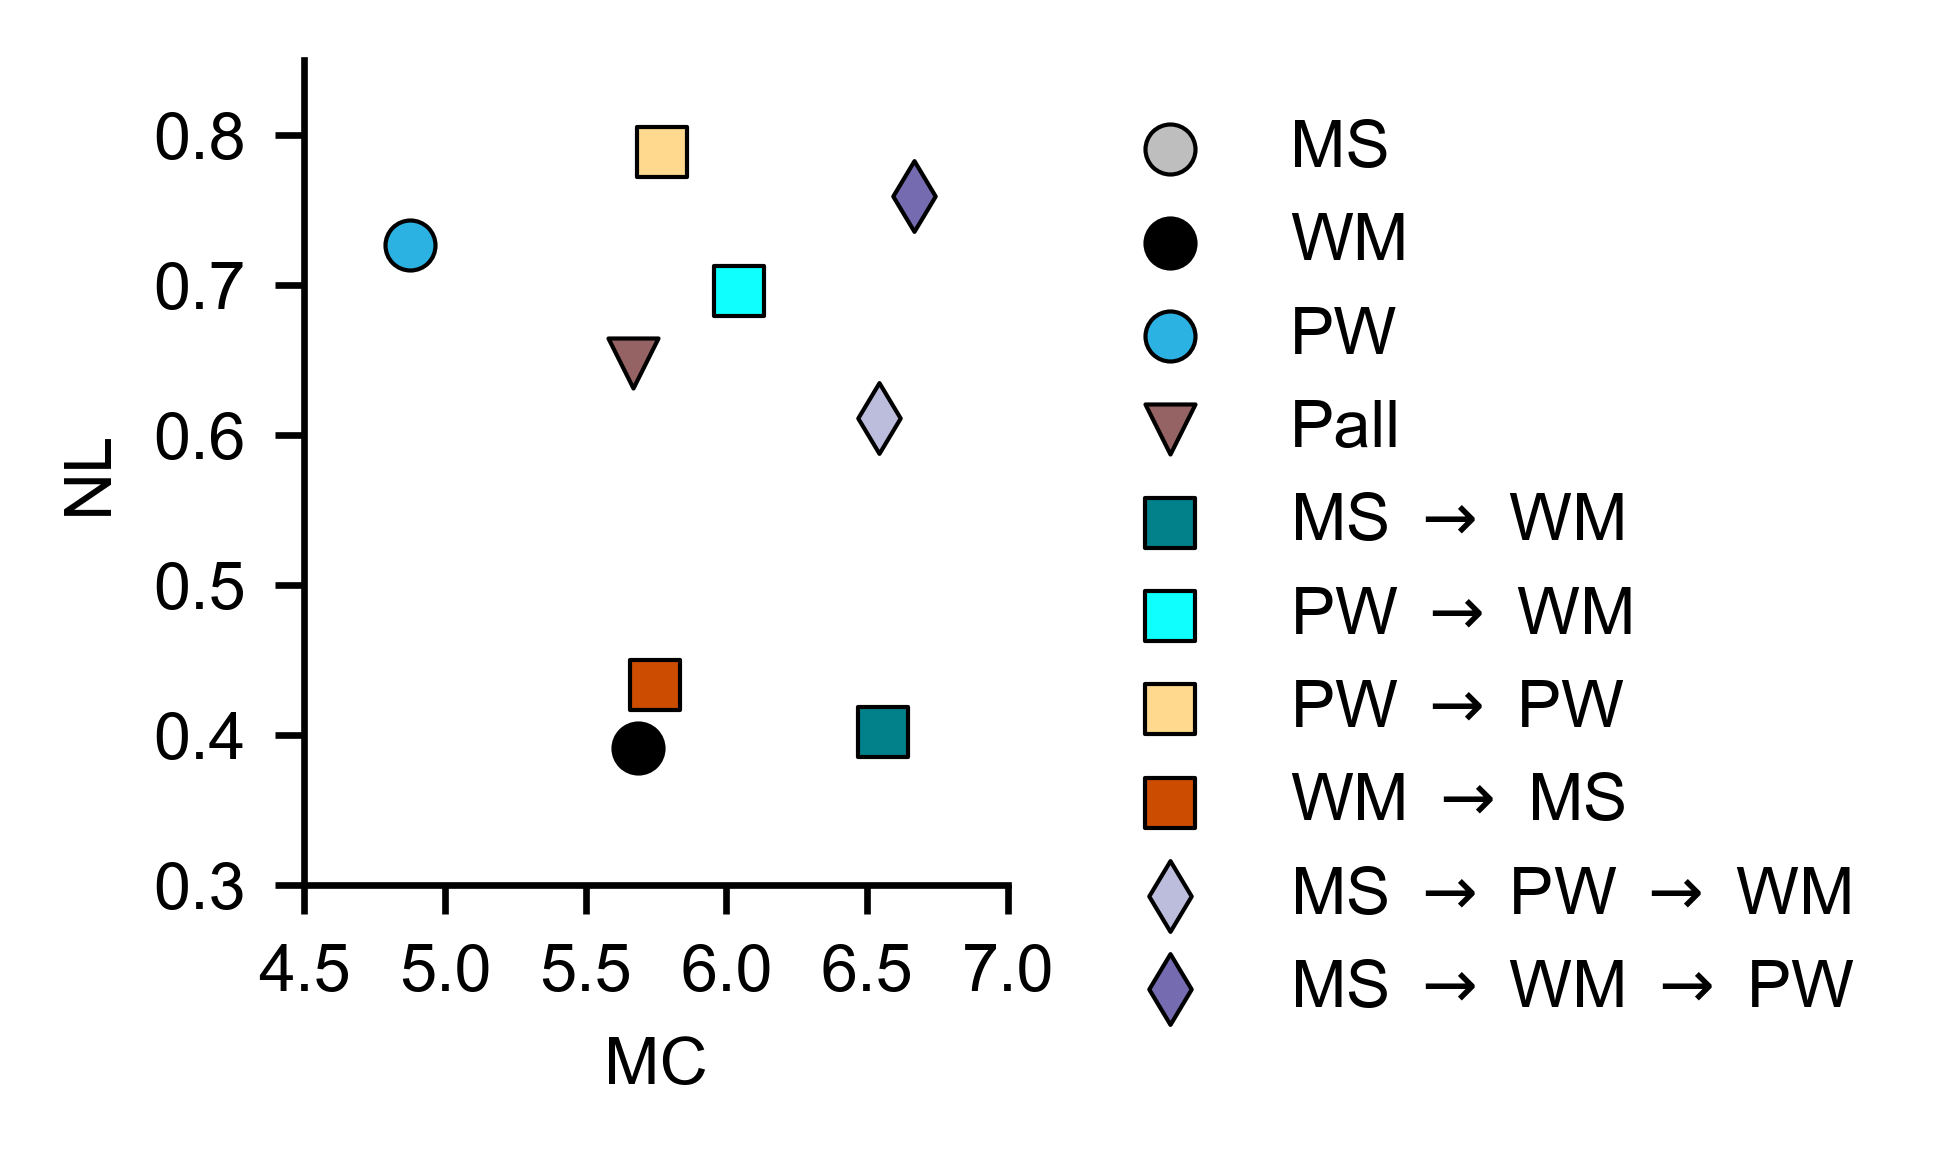

In [90]:

fig,ax = plt.subplots(1,1,figsize = (8.5*cm,5*cm))
c_list = ['#BEBEBE','k','#2BB2E3']

names = ['MS','WM','PW']
for i in range(3):
    data = objects[0][names[i]]
    MC = np.sum(data[0])
    NL = data[1]
    ax.scatter(MC,NL,c=c_list[i],label=names[i],edgecolor='k',linewidth=0.5)
    

c_list = ['#956363']
names = ['Pall']
for i in range(1):
    data = objects[0][names[i]]
    MC = np.sum(data[0])
    NL = data[1]
    ax.scatter(MC,NL,c=c_list[i],label=names[i],edgecolor='k',linewidth=0.5,marker = 'v')
    

#print(MC_H)


fs = [2,4,3]
fs = ['S34','S15','S23']
names = [r'MS $\rightarrow$ WM',r'PW $\rightarrow$ WM',r'PW $\rightarrow$ PW']

sf = [5]
sf=['S27']

triple=[10,9]
triple = [9,8]
triple = ['S39','S45']

c_list = ['#02818a','#0fffff','#fed98e']
for i in range(len(fs)):
    name = fs[i]
    data = objects[0][name]
    MC = np.sum(data[0])
    NL = data[1]
    ax.scatter(MC,NL,c=c_list[i],label=names[i],edgecolor='k',linewidth=0.5,marker='s')
c_list = ['#cc4c02']
names = [r'WM $\rightarrow$ MS']
for i in range(len(sf)):
    name = sf[i]
    data = objects[0][name]
    MC = np.sum(data[0])
    NL = data[1]
    ax.scatter(MC,NL,c=c_list[i],label=names[i],edgecolor='k',linewidth=0.5,marker='s')
c_list = ['#bcbddc','#756bb1']
names = [r'MS $\rightarrow$ PW $\rightarrow$ WM',r'MS $\rightarrow$ WM $\rightarrow$ PW']
for i in range(len(triple)):
    name = triple[i]
    data = objects[0][name]
    MC = np.sum(data[0])
    NL = data[1]
    ax.scatter(MC,NL,c=c_list[i],label=names[i],edgecolor='k',linewidth=0.5,marker='d')


plt.legend(bbox_to_anchor=(1.05, 1),frameon=False)
plt.xlim(4.5,7)
plt.ylim(0.3,0.85)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('MC')
ax.set_ylabel('NL')

ax.set_xticks([4.5,5,5.5,6,6.5,7])
ax.set_yticks([.3,.4,.5,.6,.7,.8])

plt.tight_layout()



Per channel metrics

In [60]:
## The metric calculations below are used to evaluate the per channel metrics. 
## Code is adapted from Love, Jake, et al. "Task agnostic metrics for reservoir computing." arXiv e-prints (2021): arXiv-2108.


from matplotlib.colors import LogNorm
import numpy as np
import scipy as sp
import os
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn.linear_model import LinearRegression

scaler = MinMaxScaler()
import time
def l1norm(v):
    """ NumPy L1 norm wrapper

    :param v : n-dimensional vector

    :return : L1 norm of v
    """
    return np.linalg.norm(v, ord=1)



def erank(M):
    """ Effective rank of matrix M as defined by Roy, Olivier, and Martin
        Vetterli in:

            The effective rank: A measure of effective dimensionality.
            2007 15th European Signal Processing Conference. IEEE, 2007.

    :param M : matrix in the form of a 2d numpy array 

    :return : effective rank as a floating point bound by [1.0, min(i, j)]
    """
    U, s, V = np.linalg.svd(M)

    snorm = s / l1norm(s)

    return math.exp(shannon_entropy(snorm))



def cov(X, Y):
    """ Covariance between random variables X and Y

    :param X : samples of random variable X 
    :param Y : samples of random variable Y
    """
    return np.mean(X*Y) - np.mean(X)*np.mean(Y)



def estimator_capacity(u, X):
    """ Measures the quality of a linear estimator from a multivariate series
        to reconstruct a univariate series u

    :param u : univariate series to reconstruct
    :param X : multivariate series

    :return : Measure depicting the quality of the estimator bound by the
              interval [0.0, 1.0].
    """
    n_train = int(u.shape[0] * 0.75)

    u_train = u[:n_train]
    X_train = X[:n_train]

    u_test  = u[n_train:]
    X_test  = X[n_train:]

    estimator = LinearRegression().fit(X_train, u_train) 

    u_pred = estimator.predict(X_test) # estimator reconstruction

    return cov(u_test, u_pred)**2 / (np.var(u) * np.var(u_pred))


def linear_memory_curve(u, X, kmax=25):
    """ Linear memory cuvre as defined by Herbert Jaeger

    :param u : reservoir input series
    :param X : reservoir output states

    :return : linear memory capacity at each delay interval
    """
    mc = []

    for k in range(1, kmax):

        u_k = u[:-k]  # truncated input
        X_k = X[k:]   # delayed state trajectory

        mc.append(estimator_capacity(u_k, X_k))

    return mc



def linear_memory_capacity(u, X, kmax=25):
    """ Linear memory capacity as defined by Herbert Jaeger

    :param u : reservoir input series
    :param X : reservoir output states

    :return : total linear memory capacity
    """

    return sum(mc)

def linear_memory_capacity2(u, X, kmax=100):
    """ Linear memory capacity as defined by Herbert Jaeger

    :param u : reservoir input series
    :param X : reservoir output states

    :return : total linear memory capacity
    """
    mc = linear_memory_curve(u, X, kmax)
    #plt.plot(mc)
    #plt.show()
    return sum(mc), mc

def non_linearity(u, X, k=25):
    """ Measures the non-linearity of a system by approximating it as a LTI.
        The quality of the approximation is then measured to quantify the
        linearity of the system.

    :param u : reservoir input states
    :param X : reservoir output states

    :param kmax : maximum delay of LTI kernel

    :return : value determining the non-linearity of the system bound by the
              interval [0.0, 1.0]
    """
    u_padded = np.pad(u, (k - 1), 'constant', constant_values=(0,0))

    u_history = sliding_window_view(u_padded, k)[:len(u)]

    linearity = []

    for x in np.transpose(X):

        linearity.append(estimator_capacity(x, u_history))
    #plt.plot(linearity)
    #plt.show()
    return 1 - np.mean(linearity)




def load_data(folder, datalen):
    array_init=False
    
    ## Loop through data files in each folder
    for file in os.listdir(folder):
        if '.npy' in file:
            
            # Load the data
            data=np.load(os.path.join(folder,file),allow_pickle=True)
            #print(data)
            #Seperate states and input fields
            states = data[:datalen,1:]
            input_ = data[:datalen,0].reshape(-1,1)
            #print(input_)
            # Initialise the array for all states
            if array_init==False:
                data_all = states
                input_all = input_



                array_init = True
            else:
                if len(data)>(datalen-1):
                    data_all=np.concatenate([data_all[:datalen],data[:datalen]],axis=1)
                    input_all=np.concatenate([input_all[:datalen],input_[:datalen]],axis=1)
                else:
                    print('File has less data than required - ', file)
    return data_all, input_all

In [62]:
# Per channel metrics are calculated using the above functions

folder = os.path.join(base,r'Data\Mackey_Glass\Single\WM')
states,input = load_data(folder,250)


resultsWM = []
curveWM = []
for i in range(states.shape[1]):
    
    u = scaler.fit_transform(MG_new.reshape(-1,1)).reshape(1,-1)[0]
    X = scaler.fit_transform(states[:,i].reshape(-1,1))
    #X = u.reshape(-1,1)
    #complex_val = complexity(u[:200],X[:200])
    memory, curve = linear_memory_capacity2(u[:200],X[:200],8)
    non_linear = non_linearity(u[:200],X[:200],8)

    resultsWM.append([i,memory,non_linear])
    curveWM.append(curve)

folder = os.path.join(base,r'Data\Mackey_Glass\Single\PW')
states,input = load_data(folder,250)


resultsPW = []
curvePW = []
for i in range(states.shape[1]):
    
    u = scaler.fit_transform(MG_new.reshape(-1,1)).reshape(1,-1)[0]
    X = scaler.fit_transform(states[:,i].reshape(-1,1))
    #X = u.reshape(-1,1)
    #complex_val = complexity(u[:200],X[:200])
    memory, curve = linear_memory_capacity2(u[:200],X[:200],8)
    non_linear = non_linearity(u[:200],X[:200],8)

    resultsPW.append([i,memory,non_linear])
    curvePW.append(curve)

folder = os.path.join(base,r'Data_results\Mackey_Glass\Single\MS')
states,input = load_data(folder,250)
print(states.shape)

resultsMS = []
curveMS = []
for i in range(states.shape[1]):
    
    u = scaler.fit_transform(MG_new.reshape(-1,1)).reshape(1,-1)[0]
    X = scaler.fit_transform(states[:,i].reshape(-1,1))
    #X = u.reshape(-1,1)
    #complex_val = complexity(u[:200],X[:200])
    memory, curve = linear_memory_capacity2(u[:200],X[:200],8)
    non_linear = non_linearity(u[:200],X[:200],8)

    resultsMS.append([i,memory,non_linear])
    curveMS.append(curve)

(250, 400)


148
[234.722]
159
[180.285]
(250, 525)
148
[234.722]
159
[180.285]


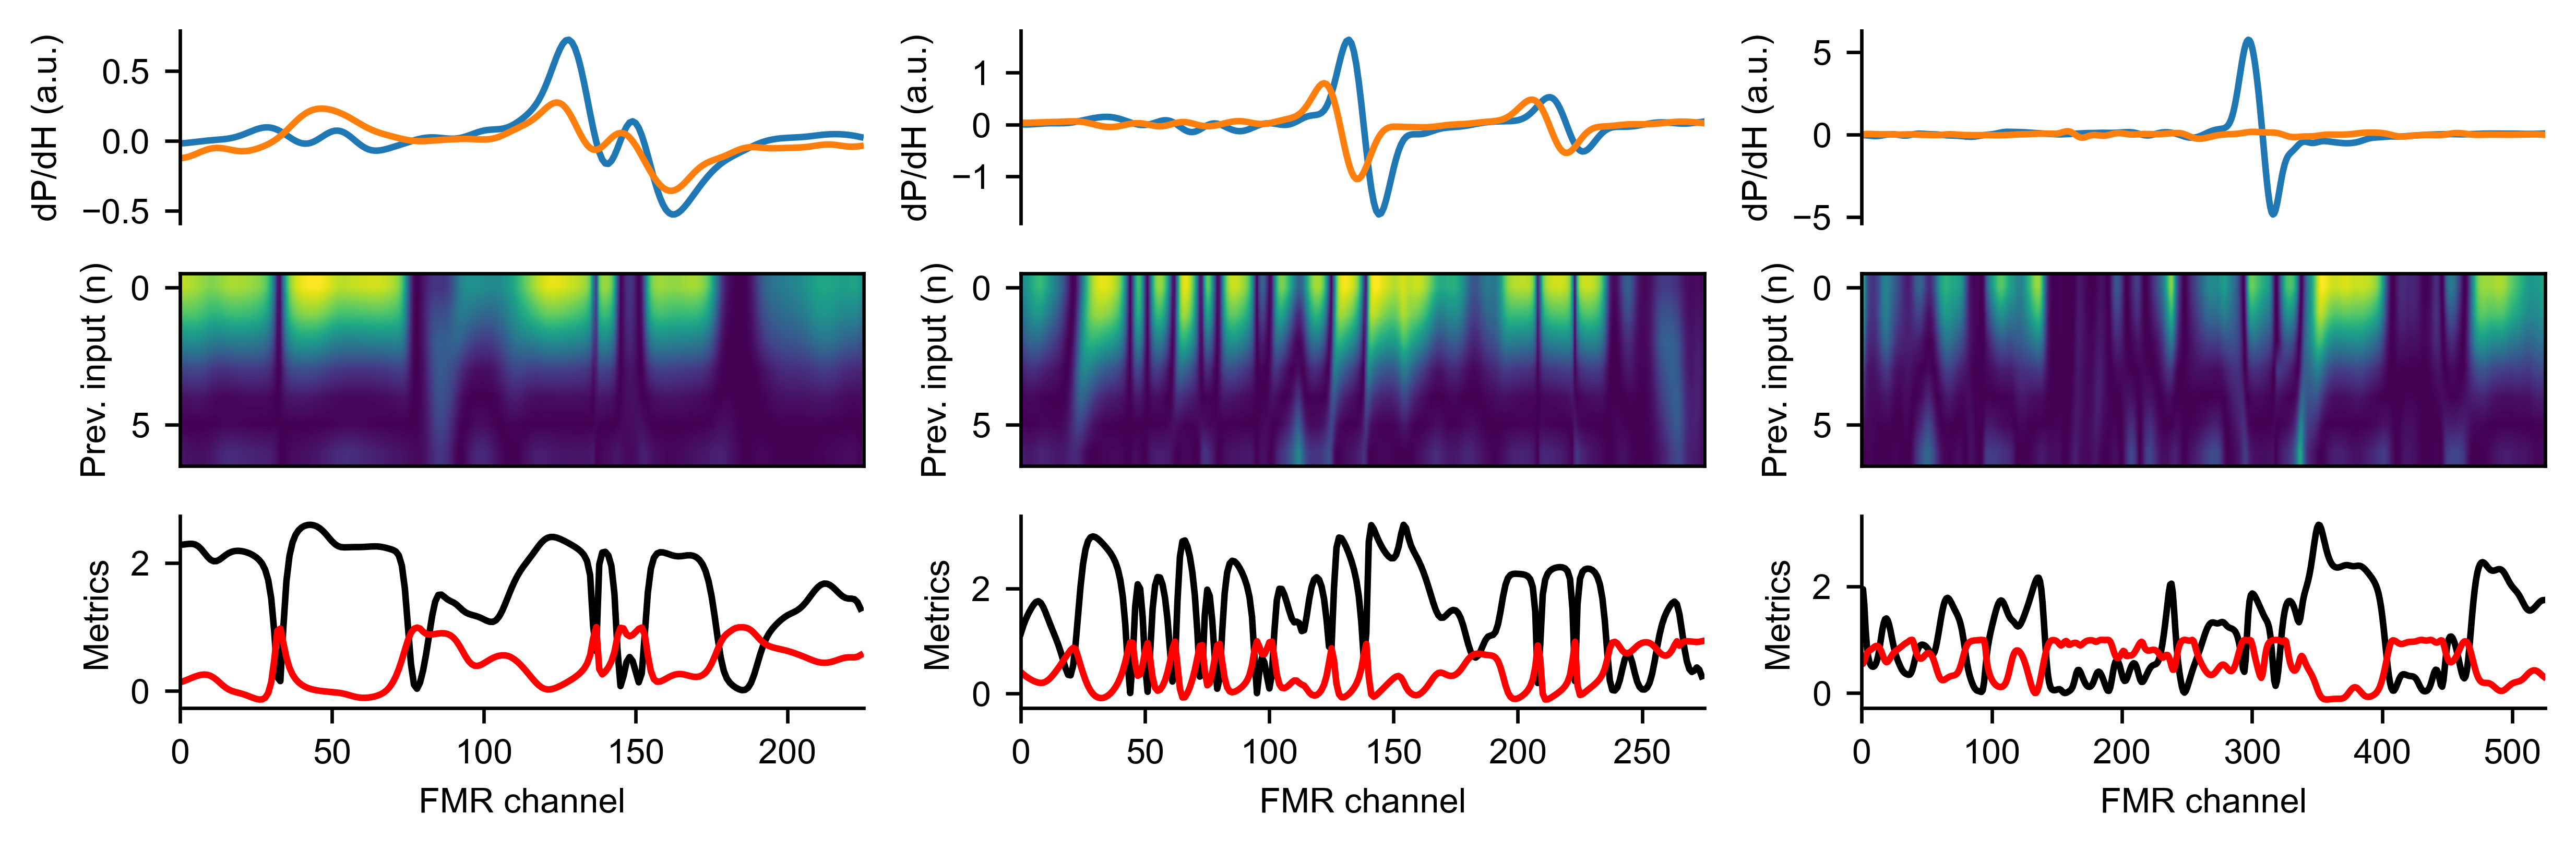

In [63]:
resultsWM = np.array(resultsWM)
resultsMS = np.array(resultsMS)
resultsPW = np.array(resultsPW)
curveWM = np.array(curveWM)
curvePW = np.array(curvePW)
curveMS = np.array(curveMS)

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"]=8
plt.rcParams['figure.dpi'] = 600
cm=1/2.54

folder = os.path.join(base,r'Data_results\Mackey_Glass\Single\WM')
statesWM,inputWM = load_data(folder,250)
folder = os.path.join(base,r'Data_results\Mackey_Glass\Single\MS')
statesMS,inputMS = load_data(folder,250)
folder = os.path.join(base,r'Data_results\Mackey_Glass\Single\PW')
statesPW,inputPW = load_data(folder,250)

imax = max(enumerate(inputWM),key=lambda x: x[1])[0]
print(imax)
print(inputWM[imax])

imin = min(enumerate(inputWM),key=lambda x: x[1])[0]
print(imin)
print(inputWM[imin])
fig,ax = plt.subplots(3,3,figsize = (21*cm,7*cm))

print(statesPW.shape)

imax = max(enumerate(inputWM),key=lambda x: x[1])[0]
print(imax)
print(inputWM[imax])

imin = min(enumerate(inputWM),key=lambda x: x[1])[0]
print(imin)
print(inputWM[imin])

ax[0][0].plot(statesMS[imax,175:])
ax[0][0].plot(statesMS[imin,175:])

ax[0][1].plot(statesWM[imax,120:])
ax[0][1].plot(statesWM[imin,120:])

ax[0][2].plot(statesPW[imax,:])
ax[0][2].plot(statesPW[imin,:])


ax[1][0].imshow(curveMS.T[:,175:],aspect='auto',interpolation='bilinear')
ax[1][1].imshow(curveWM.T[:,120:],aspect='auto',interpolation='bilinear')
ax[1][2].imshow(curvePW.T[:,:],aspect='auto',interpolation='bilinear')

ax[2][0].plot(resultsMS[175:,1],c='k')
ax[2][0].plot(resultsMS[175:,2],c='r')
ax[2][1].plot(resultsWM[120:,1],c='k')
ax[2][1].plot(resultsWM[120:,2],c='r')
ax[2][2].plot(resultsPW[:,1],c='k')
ax[2][2].plot(resultsPW[:,2],c='r')

ax[0][0].set_xlim(0,225)
ax[1][0].set_xlim(0,225)
ax[2][0].set_xlim(0,225)

ax[0][1].set_xlim(0,275)
ax[1][1].set_xlim(0,275)
ax[2][1].set_xlim(0,275)

ax[0][2].set_xlim(0,525)
ax[1][2].set_xlim(0,525)
ax[2][2].set_xlim(0,525)

for i in [0,2]:
    for j in [0,1,2]:
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)
        if i!=2:
            ax[i][j].spines['bottom'].set_visible(False)
for i in range(2):
    for j in range(3):
        ax[i][j].set_xticks([])

ax[0][0].set_ylabel('dP/dH (a.u.)')
ax[0][1].set_ylabel('dP/dH (a.u.)')
ax[0][2].set_ylabel('dP/dH (a.u.)')

ax[1][0].set_ylabel('Prev. input (n)')
ax[1][1].set_ylabel('Prev. input (n)')
ax[1][2].set_ylabel('Prev. input (n)')

ax[2][0].set_ylabel('Metrics')
ax[2][1].set_ylabel('Metrics')
ax[2][2].set_ylabel('Metrics')
ax[2][0].set_xlabel('FMR channel')
ax[2][1].set_xlabel('FMR channel')
ax[2][2].set_xlabel('FMR channel')
plt.tight_layout()


Interconnection metrics. I.e. how does the output channel of one reservoir affect the metrics of the next

In [67]:
## Analyse the memory and nonlinearity for each subnetwork w.r.t the mackey glass input

folder = os.path.join(base,r'Data\Mackey_Glass\Individual')
all_={}
for net in os.listdir(folder):
    try:
        netfold = os.path.join(folder,net)

        MG = np.load('mackey_glass_t17.npy')
        MG_new = []
        for i in range(250):
            MG_new.append(MG[2*i])
        MG_new =  (MG_new-np.min(MG_new))/(np.max(MG_new)-np.min((MG_new)))

        ths=np.array([0.999, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92])

        MC1=[]

        p_te=0.2
        Task='MC'

        Data=DATA(MG_new,netfold,p_te,Task)

        Data.CrossVal(4,1)
        Data.CORR()


        MSE_tr, MSE_val, MSE_te, RM, Best_hyper, Z_val, Z_te, MC=Data.Measure_MC(ths)

        Task='NL'

        Data=DATA(MG_new,netfold,p_te,Task)

        Data.CrossVal(4,1)
        Data.CORR()

        MSE_tr, MSE_val, MSE_te, Best_hyper, Z_val, Z_te, NL=Data.Measure_NL()

        states, inputs = load_data(netfold,250)
        u = scaler.fit_transform(MG_new.reshape(-1,1)).reshape(1,-1)[0]
        X = scaler.fit_transform(inputs.reshape(-1,1))
        #X = u.reshape(-1,1)
        #complex_val = complexity(u[:200],X[:200])
        MC_inp, curve = linear_memory_capacity2(u[:200],X[:200],8)
        NL_inp = non_linearity(u[:200],X[:200],8)

        all_[net]=[MC_inp,NL_inp,MC,NL]
        print(net,MC_inp,NL_inp,np.sum(MC),NL)    
    except:
        pass


Performance: TE,  0.04718107074587774 VAL  0.049891483999360865 TR  0.041886530112923905
MC:  2.5007822198299827
Performance: TE,  0.0303993997585624 VAL  0.03297892975728607 TR  0.02883538741418066
NL:  0.3771467686801697
A0 2.434581250418521 -0.004500642460068205 2.5007822198299827 0.3771467686801697
Performance: TE,  0.04873263996193801 VAL  0.051675379262861997 TR  0.04517553758498514
MC:  2.3210172252800403
Performance: TE,  0.04641916848149938 VAL  0.05040097277351032 TR  0.043497574787865215
NL:  0.4102292588405604
A1 2.4183195008834693 0.11703517525432461 2.3210172252800403 0.4102292588405604
Performance: TE,  0.06058827259131212 VAL  0.062455577518467795 TR  0.055154240545562526
MC:  0.9424268711036271
Performance: TE,  0.06287640901690719 VAL  0.06852336105662256 TR  0.06116650315167368
NL:  0.888590896585265
A10 2.016123014608333 0.6316845308246841 0.9424268711036271 0.888590896585265
Performance: TE,  0.020953920757559925 VAL  0.020332086941434287 TR  0.01483736481360295
MC

In [68]:
import pickle
with open(r'metrics_interconnection.pkl', 'wb') as fp:
    pickle.dump(all_, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [92]:
## Load the .pkl files with the various tasks. task+'under' has results where the PNN is forced to be in the underparameterised state by changing the theta values for the correlation

objects = []
import pickle

with open('metrics_interconnection.pkl', "rb") as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
print(objects[0]['A0'])

[2.434581250418521, -0.004500642460068205, array([0.90894208, 0.69643316, 0.43157501, 0.19900134, 0.0572508 ,
       0.01860764, 0.04706992, 0.14190226]), 0.3771467686801697]


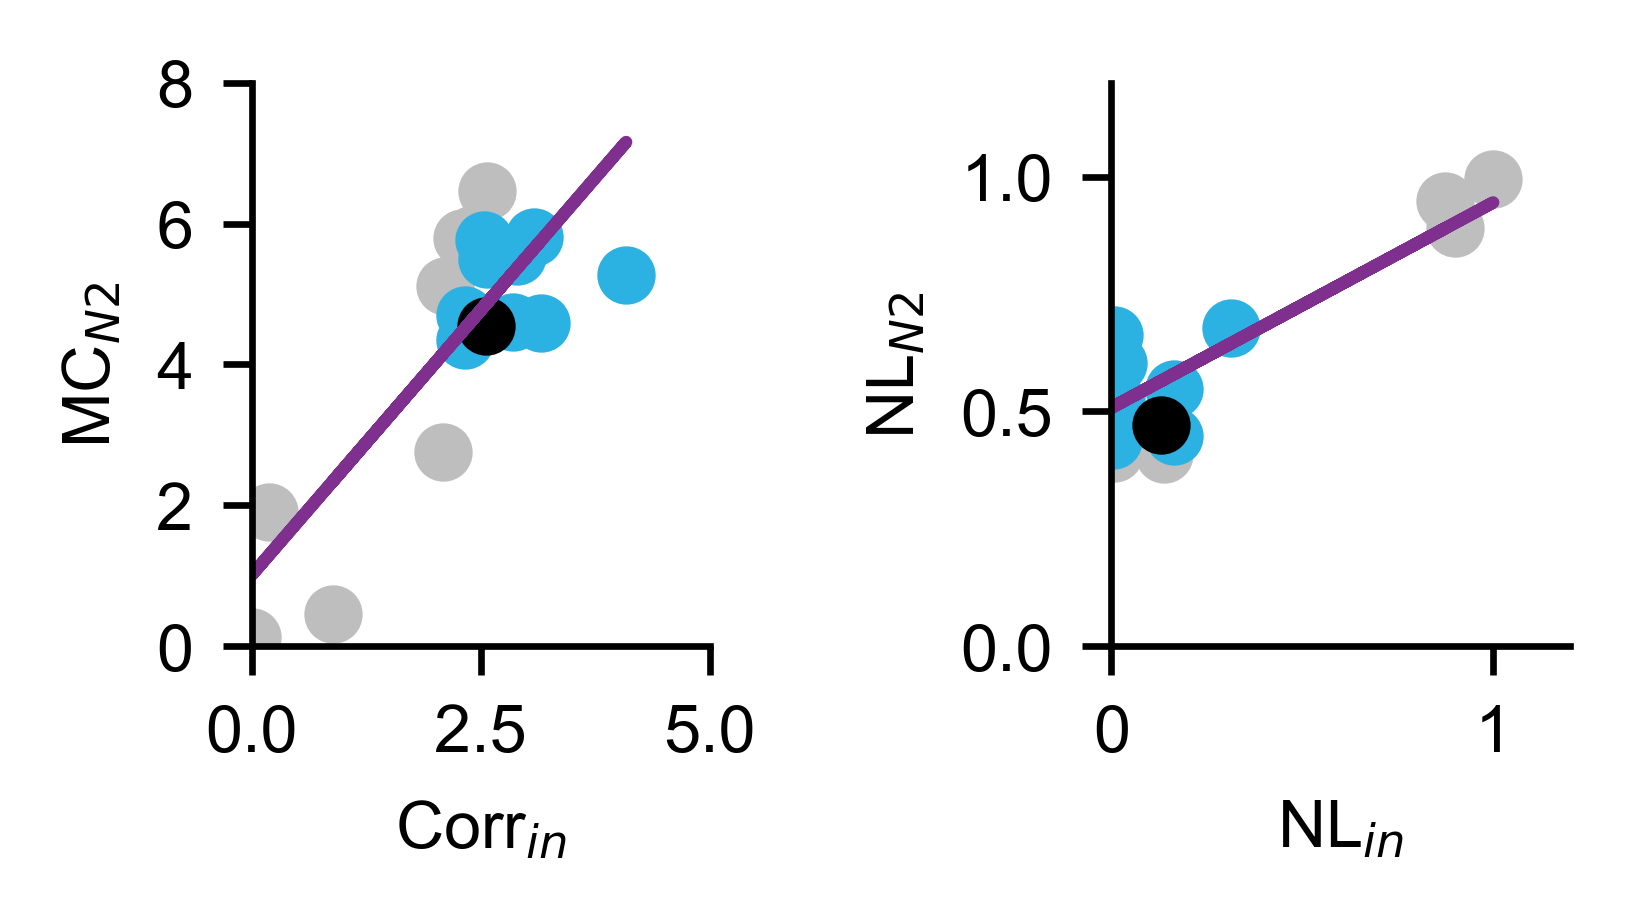

In [116]:
MSWM = ['A11','A12','A13','A31','A32','A33','A34','A35','A36']
PWWM = ['A15','A16','A17','A39','A40','A41','A42','A43','A44']
WMWM = ['A38']
c_list = ['#BEBEBE','k','#2BB2E3']
fig,ax = plt.subplots(1,2,figsize=(7*cm,4*cm))
all_MC = []
all_NL = []
for i in range(len(MSWM)):
    name = MSWM[i]
    data = objects[0][name]
    Corrin = data[0]
    NLin = data[1]
    MC = np.sum(data[2])
    NL = data[3]
    all_MC.append([Corrin,MC])
    all_NL.append([NLin,NL])
    ax[0].scatter(Corrin,MC,c=c_list[0])
    ax[1].scatter(NLin,NL,c=c_list[0])

for i in range(len(PWWM)):
    name = PWWM[i]
    data = objects[0][name]
    MC = np.sum(data[0])
    NL = data[1]
    Corrin = data[0]
    NLin = data[1]
    MC = np.sum(data[2])
    NL = data[3]
    all_MC.append([Corrin,MC])
    all_NL.append([NLin,NL])
    ax[0].scatter(Corrin,MC,c=c_list[2])
    ax[1].scatter(NLin,NL,c=c_list[2])

for i in range(len(WMWM)):
    name = WMWM[i]
    data = objects[0][name]
    MC = np.sum(data[0])
    NL = data[1]
    Corrin = data[0]
    NLin = data[1]
    MC = np.sum(data[2])
    NL = data[3]
    all_MC.append([Corrin,MC])
    all_NL.append([NLin,NL])
    ax[0].scatter(Corrin,MC,c=c_list[1])
    ax[1].scatter(NLin,NL,c=c_list[1])

from scipy import stats
all_MC = np.array(all_MC)
all_NL = np.array(all_NL)

resMC = stats.linregress(all_MC[:,0], all_MC[:,1])
resNL = stats.linregress(all_NL[:,0], all_NL[:,1])   
ax[0].plot(np.array(all_MC[:,0]), resMC.intercept + resMC.slope*np.array(all_MC[:,0]), '#7f308e')
ax[1].plot(np.array(all_NL[:,0]), resNL.intercept + resNL.slope*np.array(all_NL[:,0]), '#7f308e')

ax[0].set_xlabel(r'Corr$_{in}$')
ax[1].set_xlabel(r'NL$_{in}$')
ax[0].set_ylabel(r'MC$_{N2}$')
ax[1].set_ylabel(r'NL$_{N2}$')
ax[0].set_xlim(0,5)
ax[1].set_xlim(0,1.2)
ax[0].set_ylim(0,8)
ax[1].set_ylim(0,1.2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.tight_layout()
